## Principal Component Analysis. Part III: The real PCA

In [1]:
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import pandas as pd
import time
from matplotlib.pyplot import figure
import math as mt
from scipy import integrate
import sys
import warnings
time0 = time.perf_counter()

 It is added the clusters variable. A binary variable that will be used later. Just remember to activate it if needed. If you are using real data put 
 
 clusters = False

In [2]:
clusters = True # you want to prove the PCA analysis? then put this variable in True!

#### Navigating the cube
As shown in other codes, we navigate the MIRI cube and make the changes we think are needed for this analysis.

In [3]:
spec_dir = '/home/povalle/notebook/data_products/'
channel = '2'  # 1 // 2 // 3 // 4 // all
band = 'short' # shor // medi // long // all
filesave = '/home/povalle/notebook/extraction/data/'
low = 1250
up= 1325
scale = 1e6*1e-26/((3.335641e-11)*1e4) # Changing to W/cm2 sr cm-1
scale = scale*1.1 # because of the oversized PSF of MIRIsim (REMOVE WITH REAL DATA)
filedf = 'mergedspectra.txt'


filename= 'jupiter_ch4.res'
df = pd.read_csv(filename, sep='\s+', header = None)
df[0] = 10**4/df[0]
wavex = df[0]
spex = df[2]

if channel=='all':
    filename = spec_dir + 'allcube_ch1-2-3-4-mediumshortlong-_s3d.fits'
else:
    filename = spec_dir + 'Level3_ch' + str(channel) + '-' + str(band) + '_s3d.fits'
    
hdu = fits.open(filename)
hdr = hdu['SCI'].header
data = hdu['SCI'].data
RA = hdu['SCI'].header['RA_V1']
DEC = hdu['SCI'].header['DEC_V1']
CRPIX1 = hdu['SCI'].header['CRPIX1']
CRPIX2 = hdu['SCI'].header['CRPIX2']

ny = data.shape[1]
nx = data.shape[2]

if channel=='all':
    wave = hdu['WCS-TABLE'].data['wavelength'][0] #IF WORKING WITH 4 CHANNEL CUBE
else:    
    wave = np.arange(hdr['NAXIS3'])*hdr['CDELT3']+hdr['CRVAL3'] #IF WORKING WITH 1 CHANNEL or SUBBAND CUBE
    
wave = wave + 0.0033
wave = np.array(wave)
lenwave = int(len(wave))

wavenumber = 10**4/wave
for ix in range(len(wavenumber)):
            if wavenumber[ix] < low:
                lower = ix
                break
for iix in range(len(wavenumber)):
            if wavenumber[iix] < up:
                upper = iix
                break

#### Creating the master dataframe (clean and remove lines)

We clean the spectra. In MIRIsim we get some spectra with corrupted data (values go down to zero). For the PCA, we need to remove all of them. After that we create a master dataframe df. If the variable cluster i on (cluster=1), then the code changes three spectra of the 1200 by removing some emission lines in order to see how the PCA is able to identify them by clustering, as we will see in the final visualization.

A second dataframe (dfx) is created in order to store the spatial information of every spaxel.

In [4]:
warnings.filterwarnings("ignore")
df = pd.DataFrame(wave)
dfx = pd.DataFrame({0:[0, 1]})
m = 1
for i in range(ny):
    for ii in range(nx):
        if sum(data[:,i,ii]*scale) !=0 :
            df[m] = data[:,i,ii]*scale
            dfx[m] = [i,ii]
            m = m + 1

for i in range(df.shape[1]):
    count = (df[i] == 0).sum()
    count = int(count)
    if count > 1:
        df = df.drop(columns=[i])
        dfx = dfx.drop(columns=[i])
        
df.to_csv(filedf, header=None, 
          index=None, sep=' ')
df = pd.read_csv(filedf, header=None, sep='\s+')
df = df.drop(columns=[0])

dfx.to_csv(filedf, header=None, 
          index=None, sep=' ')
dfx = pd.read_csv(filedf, header=None, sep='\s+')

if clusters == True:
    k = np.linspace(0.1e-7,0.07e-7,25)
    df[df.shape[1]-1][100:125] = k
    df[df.shape[1]-2][100:125] = k
    df[df.shape[1]-5][100:125] = k
    k = np.linspace(0.05e-7,0.07e-7,20)
    df[df.shape[1]-1][160:180] = k
    df[df.shape[1]-2][160:180] = k
    df[df.shape[1]-5][160:180] = k
df

,1,2,3,4,5,6,7,8,9,10,...,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185
0,4.358876e-09,3.993168e-09,3.902826e-09,3.868369e-09,4.237903e-09,3.619014e-09,3.598226e-09,3.646688e-09,3.676094e-09,3.945899e-09,...,8.273448e-09,7.664641e-09,7.808638e-09,9.860915e-09,1.105829e-08,1.111258e-08,7.763668e-09,1.017214e-08,1.110616e-08,1.110766e-08
1,4.206282e-09,4.129420e-09,4.074037e-09,4.049780e-09,4.076491e-09,3.734902e-09,3.757347e-09,3.855070e-09,3.904258e-09,4.128510e-09,...,8.519561e-09,8.426938e-09,8.716063e-09,1.089157e-08,1.198101e-08,1.216314e-08,8.581836e-09,1.153258e-08,1.201901e-08,1.221223e-08
2,4.088199e-09,4.067737e-09,4.084302e-09,4.123733e-09,4.141640e-09,3.998715e-09,3.922364e-09,4.009246e-09,4.068820e-09,4.143646e-09,...,8.402197e-09,8.474404e-09,8.918687e-09,1.120068e-08,1.257546e-08,1.352094e-08,8.733367e-09,1.191185e-08,1.269344e-08,1.367712e-08
3,6.700290e-09,6.735681e-09,6.682536e-09,6.683286e-09,6.650305e-09,6.979646e-09,6.644232e-09,6.800452e-09,6.937234e-09,6.983627e-09,...,1.331342e-08,1.354635e-08,1.399600e-08,1.698194e-08,1.900426e-08,2.013577e-08,1.355628e-08,1.762145e-08,1.924839e-08,2.023012e-08
4,1.365293e-08,1.390826e-08,1.385813e-08,1.377121e-08,1.387640e-08,1.423743e-08,1.371235e-08,1.411566e-08,1.427419e-08,1.411497e-08,...,2.492079e-08,2.501046e-08,2.560298e-08,2.978353e-08,3.282146e-08,3.403472e-08,2.479703e-08,3.033221e-08,3.306639e-08,3.406674e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,1.274666e-08,1.280559e-08,1.282974e-08,1.287864e-08,1.288782e-08,1.205409e-08,1.230609e-08,1.212834e-08,1.206632e-08,1.246591e-08,...,2.164179e-08,2.181489e-08,2.284391e-08,2.744065e-08,2.947488e-08,2.988988e-08,2.268712e-08,2.844162e-08,2.952937e-08,2.996727e-08
627,1.770218e-08,1.762114e-08,1.750253e-08,1.752163e-08,1.752884e-08,1.638527e-08,1.668163e-08,1.675326e-08,1.681119e-08,1.731321e-08,...,2.947935e-08,2.942849e-08,3.040718e-08,3.619066e-08,3.919050e-08,3.942106e-08,3.028339e-08,3.712027e-08,3.923742e-08,3.946996e-08
628,1.937691e-08,1.933953e-08,1.927146e-08,1.924578e-08,1.924465e-08,1.808328e-08,1.826079e-08,1.852236e-08,1.861702e-08,1.902923e-08,...,3.146488e-08,3.143224e-08,3.249439e-08,3.821780e-08,4.162073e-08,4.133258e-08,3.272027e-08,3.924251e-08,4.164574e-08,4.128942e-08
629,1.731043e-08,1.733158e-08,1.729871e-08,1.728994e-08,1.730942e-08,1.635615e-08,1.713519e-08,1.731175e-08,1.745164e-08,1.747377e-08,...,2.801606e-08,2.811639e-08,2.934544e-08,3.420425e-08,3.755348e-08,3.719970e-08,3.002199e-08,3.516736e-08,3.759834e-08,3.714105e-08


We create two arrays with the information of the x and y pixel position to try to find patterns in the image after the PCA.

In [5]:
array_x = dfx.iloc[0]
array_y = dfx.iloc[1]

We can check how the spectra looks like, comparing it with a normal spectra. If cluster=1 then you will note the lack of some spectral lines. If not the spectra will be quite similar.

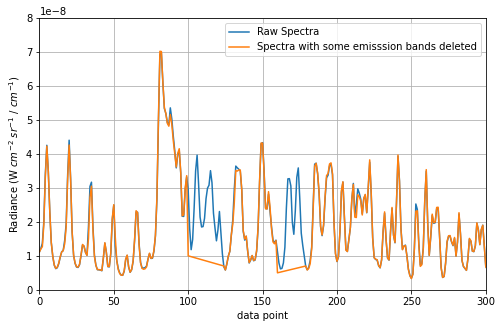

In [6]:
ax = plt.gca()

df.plot(y=df.shape[1],ax=ax)
df.plot(y=df.shape[1]-1,ax=ax, figsize=(8,5))
ax.set_xlim(0,300)
ax.set_ylim(0,8e-8)
ax.legend(['Raw Spectra','Spectra with some emisssion bands deleted'])
ax.set_xlabel('data point')
ax.set_ylabel('Radiance (W $cm^{-2}$ $sr^{-1}$ / $cm^{-1}$)')
ax.grid()

We are going to transpose the dataframe in order to make the data analysis easier for the pca library. We save the df again to have it if needed.

In [7]:
df = df.transpose()
df.to_csv(filedf, header=None, 
          index=None, sep=' ')
df = pd.read_csv(filedf, header=None, sep='\s+')

### Primary Components Analysis

We import the Machine learning libraries.

In [8]:
from sklearn.preprocessing import scale # Data scaling
from sklearn import decomposition #PCA

np.array: Transform the df to a float64 array

scale: Center to the mean and component wise scale to unit variance

In [9]:
X = np.array(df)
X = scale(X)

pca decomposition: Principal component analysis (PCA). Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

We fit the number of components (3 is more than okay since will have around 90% of the info and we will be able to represent the data in a 3D environment to find some clustering).

In [10]:
pca = decomposition.PCA(n_components=3)
pca.fit(X)

PCA(n_components=3)

We do the PCA analysis to our sample

In [11]:
scores = pca.transform(X)

We create the dataframe and specify the color. All of the are blue instead of the three spectra that can change in function of the value of the variable cluster.

We add two columns with the pixel position.

In [58]:
scores_df = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3'])
scores_df['color'] = 'blue'

scores_df['color'][df.shape[0]-2] = 'red'
scores_df['color'][df.shape[0]-3] = 'red'
scores_df['color'][df.shape[0]-6] = 'red'

scores_df['x'] = array_x
scores_df['y'] = array_y

df_scores = scores_df
df_scores

,PC1,PC2,PC3,color,x,y
0,-19.510345,1.921697,0.279675,blue,0,1
1,-19.589953,1.951914,0.229746,blue,1,23
2,-19.601050,1.950749,0.224880,blue,1,24
3,-19.581246,1.927240,0.225364,blue,1,25
4,-19.566408,1.915004,0.221620,blue,1,26
...,...,...,...,...,...,...
1180,32.712717,0.202837,0.225745,blue,35,24
1181,9.821625,-1.427669,0.008321,blue,35,25
1182,23.403064,0.383438,11.256064,red,36,22
1183,29.396910,0.758879,12.510209,red,36,23


The importance of every spectra for the three Pricipal component variables is obtained with .components_.T so the sum of every PC1 + PC2 + PC3 is 1. 

In [59]:
loadings = pca.components_.T
df_loadings = pd.DataFrame(loadings, columns=['PC1', 'PC2','PC3'])
df_loadings

,PC1,PC2,PC3
0,0.039692,0.016325,-0.023380
1,0.039891,0.008043,-0.012128
2,0.039782,0.014622,-0.006699
3,0.039758,0.003324,-0.003743
4,0.039677,-0.015116,-0.008507
...,...,...,...
626,0.039892,-0.004487,0.022083
627,0.039894,-0.020849,0.021411
628,0.039901,-0.025150,0.019293
629,0.039893,-0.021457,0.018012


We also can see how much of the info is stored in every variable. The information will be mostly in PC1 and will decrease fast.

In [60]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([9.92248900e-01, 1.80935707e-03, 7.80198300e-04])

A calculation and representation of the cumulative variance and the variance is shown below. You can zoom in in the plots if you want.

In [61]:
import plotly.express as px

explained_variance = np.insert(explained_variance, 0, 0)
cumulative_variance = np.cumsum(np.round(explained_variance, decimals=3))
pc_df = pd.DataFrame(['','PC1', 'PC2', 'PC3'], columns=['PC'])
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=['Cumulative Variance'])
df_explained_variance = pd.concat([pc_df, explained_variance_df, cumulative_variance_df], axis=1)
df_explained_variance

,PC,Explained Variance,Cumulative Variance
0,,0.000000,0.000
1,PC1,0.992249,0.992
2,PC2,0.001809,0.994
3,PC3,0.000780,0.995


In [62]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_explained_variance['PC'],
        y=df_explained_variance['Cumulative Variance'],
        marker=dict(size=15, color="LightSeaGreen")
    ))

fig.add_trace(
    go.Bar(
        x=df_explained_variance['PC'],
        y=df_explained_variance['Explained Variance'],
        marker=dict(color="RoyalBlue")
    ))

fig.show()

#### 3D representation and clustering

We finally plot the 3D scattered data. As said before, the three spectra that can be modified are shown in red. 
##### Cluster = 0
We see that all the spectra are in the same cluster with a well defined shape. This is because the spectra are actually synthetic spectra, which means that they are strongly correlated. In a real case we should expect a bigger dispersion.
##### Cluster = 1
We can see how the three spectra are in other place, creating a mini cluster of three dots. We see that PCA can note the lack of some spectral lines pretty well. In case you are using real data, please remove the ranges and let the code autoscale the scatter plot, since maybe your PCA will be out of the boundaries of this plot.


In [74]:
time1 = time.perf_counter()
print(f"Runtime of the extraction: {time1 - time0:0.1f} seconds")

fig = px.scatter_3d(df_scores, x='PC1', y='PC2', z='PC3',
              opacity=0.5, color = 'color', range_x =(-40,70), range_y =(-3,3), range_z =(-3,15),
                   hover_data = ['x','y'])
                   
    
# Remove ranges for your analysis. Here I use them only to better the visualization

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig

Runtime of the extraction: 1643.7 seconds


#### 2D representation and clustering

We can also spot these weird spaxels in a hotmap. We must choose which variable (PC 1,2 or 3) we want to plot. If we plot PC3 by setting up the variable 'analysis', we spot these spaxels as hotspots in the lower part of the image.

In [ ]:
analysis = 'PC3' # PC1, PC2 or PC3

maxrow=int(scores_df['x'].max())
maxcol=int(scores_df['y'].max())
arr=np.zeros((maxrow,maxcol))

for index, row in scores_df.iterrows():
    i=int(row['x'])-1
    j=int(row['y'])-1
    value=row[analysis]
    arr[i,j]=value

figure(figsize=(8, 5), dpi=80)
plt.imshow(arr, aspect='auto')
plt.colorbar()

### DONT FORGET

If you are using real data, put cluster to zero or any value except one, in order to not change anything on your spectra.

Part of the code is taken from https://github.com/dataprofessor/code/blob/master/python/PCA_analysis.ipynb for the PCA analysis of the IRIS file, widely used in Machine Learning for teaching.